In [92]:
import nolearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context='poster', style='dark')

# file kfkd.py
import os

from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

from lasagne import layers
from lasagne.updates import sgd, nesterov_momentum, rmsprop, adagrad
from nolearn.lasagne import NeuralNet

from __future__ import print_function

In [2]:
FTRAIN = 'training.csv'
FTEST = 'test.csv'

In [101]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y
    
    
def plot_training_history(net0, yscale='log'):
    import matplotlib.pyplot as plt
    train_loss = np.array([i["train_loss"] for i in net0.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
    
    fig = plt.figure()
    
    fig = plt.yscale(yscale)
        
    fig = plt.plot(train_loss, '-r', label="train",)
    fig = plt.plot(valid_loss, label="valid")
    fig = plt.grid()
    fig =  plt.legend()
    fig = plt.xlabel("epoch")
    fig = plt.ylabel("loss")
    
    return fig


def plot_sample(x, y, axis, dot_color = 'magenta'):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='o', s=15, color=dot_color)
    
    
def plot_faces(X_test, y_pred, dot_color = 'magenta'):
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(X_test[i], y_pred[i], ax, dot_color = dot_color)

    plt.show()
    

# train dataset

def plot_train_comparison(net):
    y_pred_1 = net.predict(X)

    print('ground truth:')
    plot_faces(X, y, dot_color='blue')

    print('\nprediction:')
    plot_faces(X, y_pred_1)
    
    
def plot_test_pred(net):
    y_pred_test = net.predict(X_test)
    plot_faces(X_test, y_pred_test)

In [5]:
X, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [5]:
np.shape(X)

(2140, 9216)

In [6]:
np.shape(y)

(2140, 30)

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.12204       0.05870      2.07899  0.23s
      2       0.05190       0.04595      1.12944  0.22s
      3       0.04007       0.03583      1.11853  0.22s
      4       0.03207       0.03084      1.04001  0.21s
      5       0.02798       0.02799      0.99965  0.21s
      6       0.02556       0.02620      0.97550  0.21s
      7       0.02394       0.02489      0.96189  0.21s
      8       0.02275       0.02385      0.95358  0.22s
      9       0.02183       0.02309      0.94552  0.22s
     10       0.02112       0.02247      0.93964  0.23s
     11       0.02055       0.02198      0.93483  0.23s
     12       0.02007       0.02156      0.93081  0.21s
     13       0.01966       0.02119      0.9

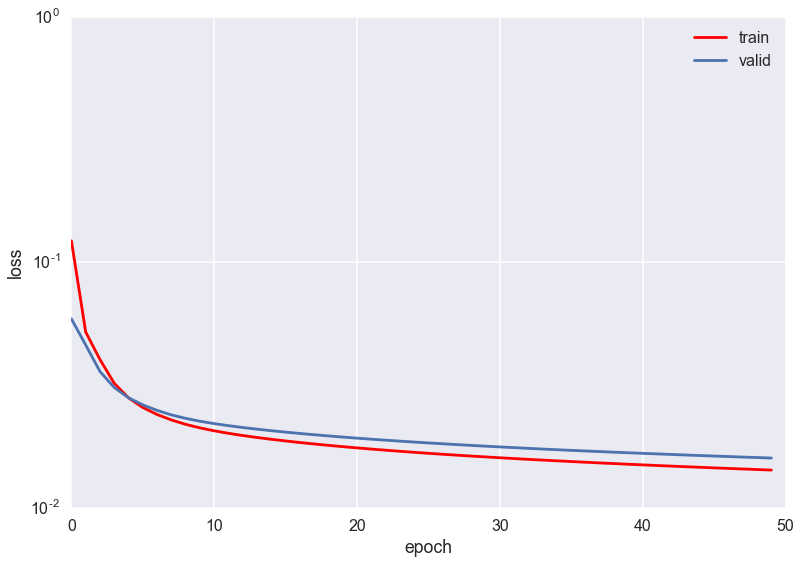

In [95]:
# simple ANN with one layer

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net0 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        ,('hidden', layers.DenseLayer)
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=sgd,
    update_learning_rate=0.01,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=50,  # we want to train this many epochs
    verbose=1,
)

net0.fit(X, y)
plot_training_history(net0)

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.19675       0.04917      4.00163  0.26s
      2       0.02747       0.01634      1.68036  0.24s
      3       0.01421       0.01489      0.95399  0.25s
      4       0.01309       0.01364      0.95946  0.26s
      5       0.01195       0.01281      0.93353  0.24s
      6       0.01128       0.01228      0.91917  0.23s
      7       0.01081       0.01183      0.91391  0.23s
      8       0.01042       0.01144      0.91037  0.23s
      9       0.01008       0.01110      0.90797  0.23s
     10       0.00979       0.01080      0.90642  0.24s
     11       0.00952       0.01052      0.90539  0.23s
     12       0.00929       0.01027      0.90476  0.23s
     13       0.00908       0.01003      0.9

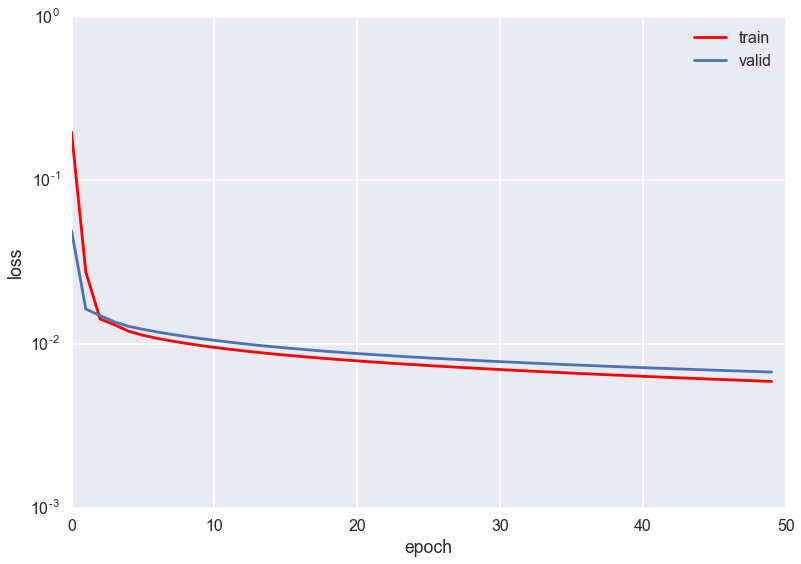

In [97]:
# change update to nesterov_momentum
# it's named after a Russian guy; must be good

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        ,('hidden', layers.DenseLayer)
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=50,  # we want to train this many epochs
    verbose=1,
)

net1.fit(X, y)
plot_training_history(net1)

ground truth:


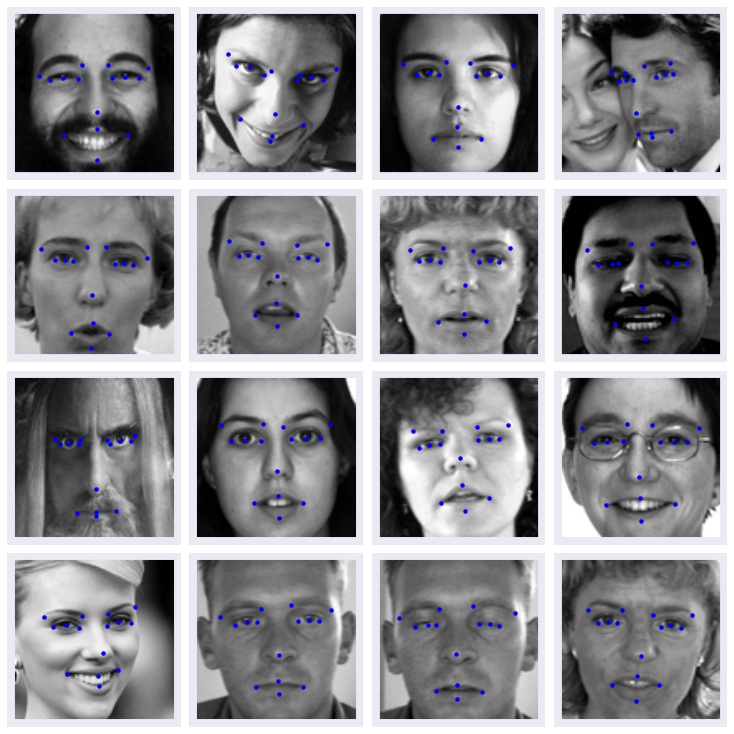


prediction:


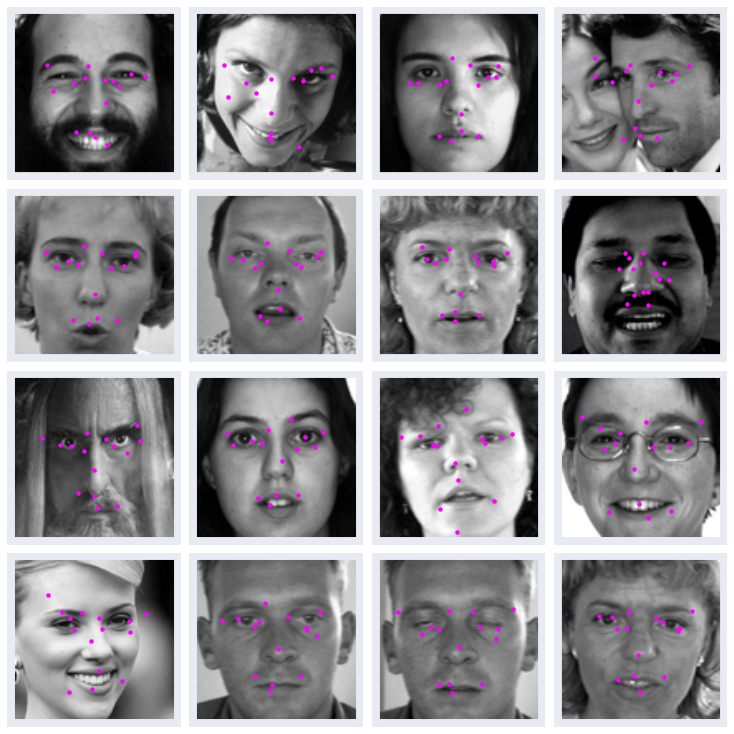

In [99]:
plot_train_comparison(net0)

ImageId    1783
Image      1783
dtype: int64


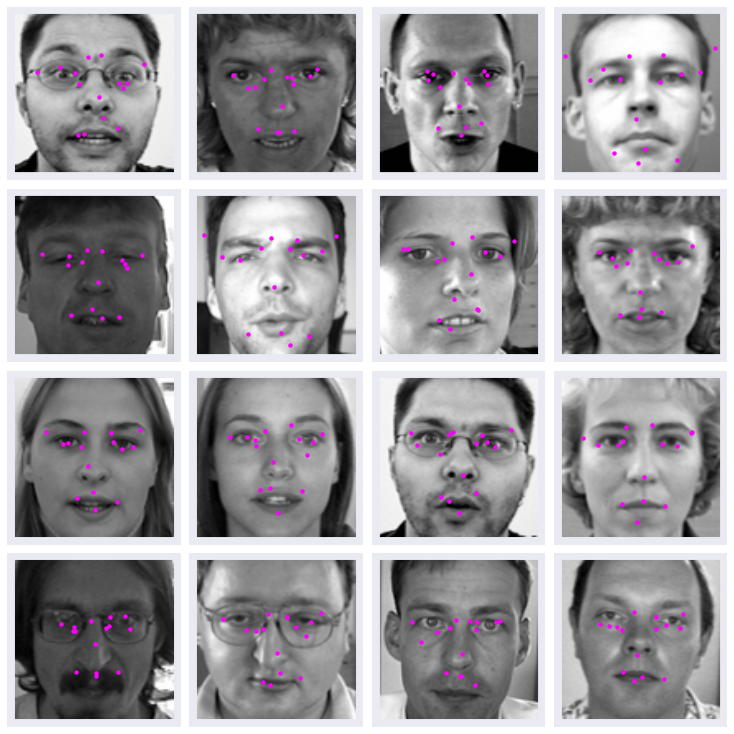

In [102]:
# test dataset

X_test, _ = load(test=True)
    
plot_test_pred(net0)

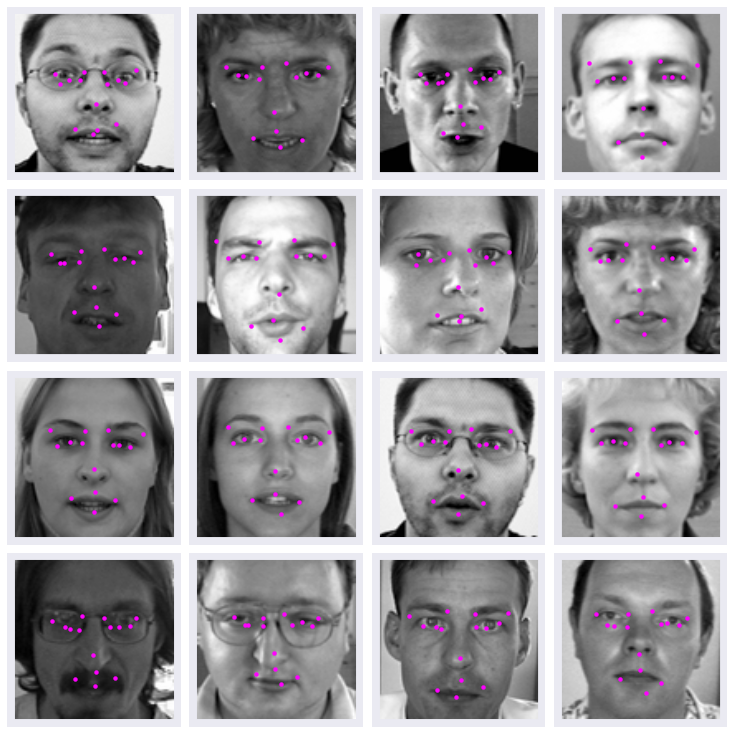

In [103]:
plot_test_pred(net1)

In [105]:
# add a layer
# a few more layers, and it can beat AlphaGo

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net3 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        ,('hidden1', layers.DenseLayer)
        ,('hidden2', layers.DenseLayer)        
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden1_num_units=100,  # number of units in hidden layer
    hidden2_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=50,  # we want to train this many epochs
    verbose=1,
)

net3.fit(X, y)

# Neural Network with 934830 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input      9216
  1  hidden1     100
  2  hidden2     100
  3  output       30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.08880       0.02341      3.79406  0.25s
      2       0.01737       0.01619      1.07240  0.23s
      3       0.01416       0.01413      1.00212  0.23s
      4       0.01263       0.01316      0.95971  0.25s
      5       0.01188       0.01255      0.94612  0.23s
      6       0.01136       0.01203      0.94464  0.25s
      7       0.01092       0.01160      0.94176  0.24s
      8       0.01055       0.01121      0.94081  0.25s
      9       0.01022       0.01085      0.94192  0.26s
     10       0.00992       0.01054      0.94149  0.24s
     11       0.00965       0.01025      0.94138  0.24s
     12       0.00940       0.00999      0.94185  0.24s
     13       0.00

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10d7ff250>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10d7ff110>,
     custom_scores=None, hidden1_num_units=100, hidden2_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden1', <class 'lasagne.layers.dense.DenseLayer'>), ('hidden2', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=50, more_params={},
     objective=<function objective at 0x10d8079b0>,
     objective_loss_function=<function squared_error at 0x10d61b5f0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x111f7af80>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x111f7a0e0>],
     output_nonlinearity=None, output_num_units=30, regr

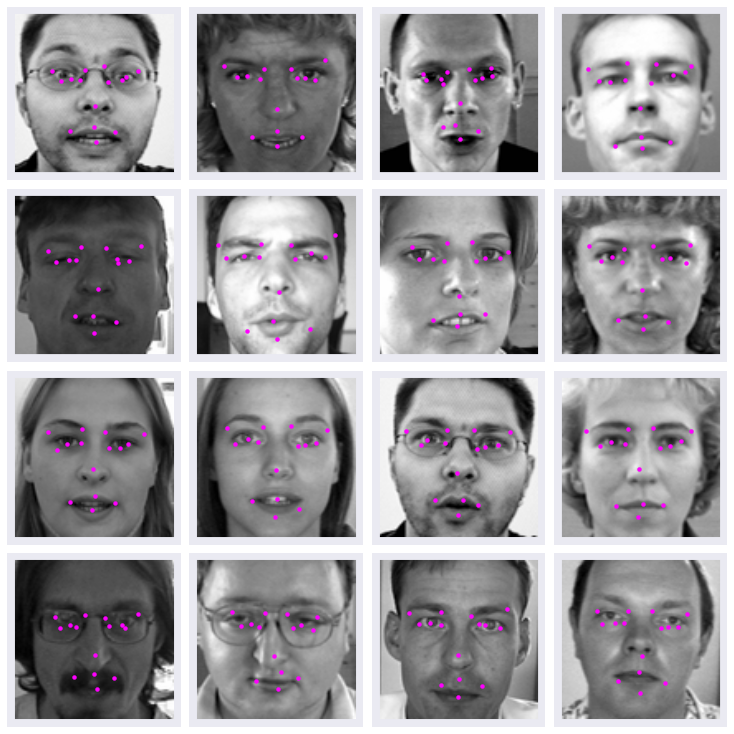

In [106]:
plot_test_pred(net3)

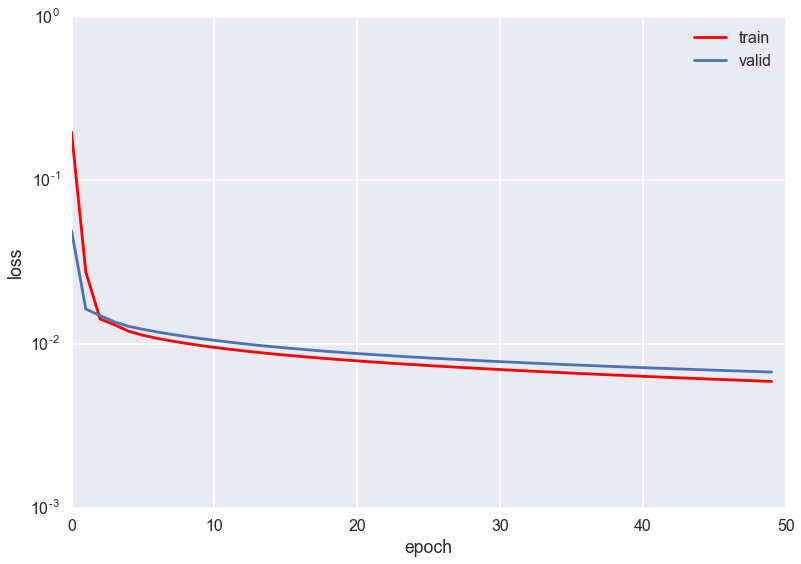

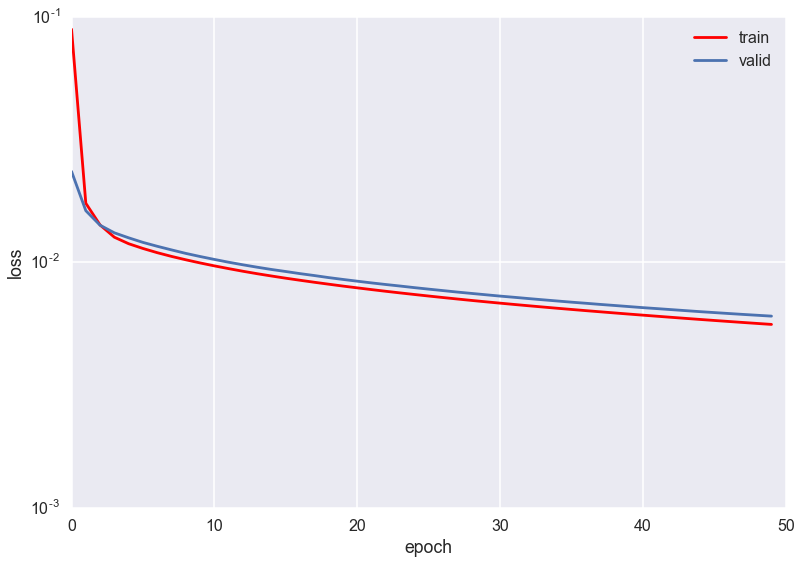

In [107]:
plot_training_history(net1)
plot_training_history(net3)

# Neural Network with 934830 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input        9216
  1  dropout_0    9216
  2  hidden1       100
  3  dropout_1     100
  4  hidden2       100
  5  output         30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.21354       0.09028      2.36521  0.64s
      2       0.08617       0.04690      1.83730  0.60s
      3       0.05751       0.03170      1.81416  0.59s
      4       0.04588       0.02887      1.58909  0.62s
      5       0.03755       0.02247      1.67109  0.60s
      6       0.03384       0.02379      1.42263  0.59s
      7       0.02975       0.02282      1.30413  0.61s
      8       0.02641       0.02057      1.28399  0.61s
      9       0.02372       0.01880      1.26131  0.59s
     10       0.02233       0.01983      1.12625  0.58s
     11       0.01988       0.01806      1.10079  0.59s
     12       0.

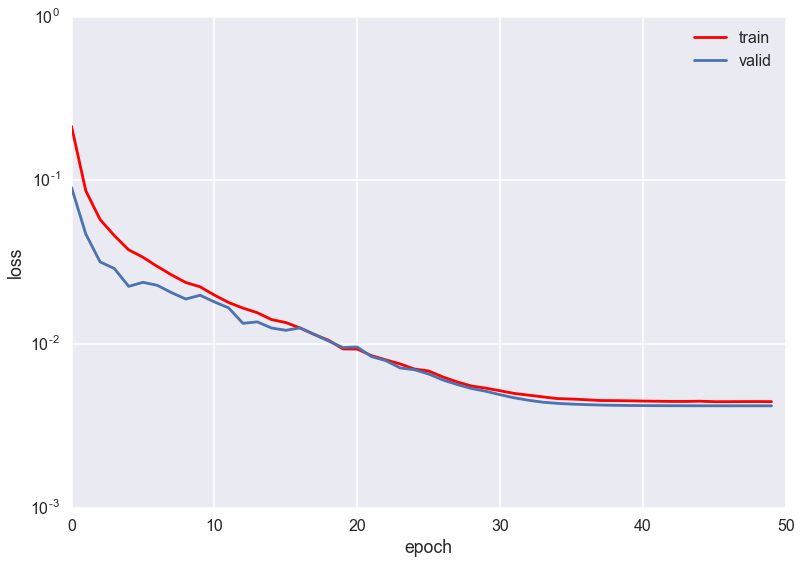

In [108]:
# add dropout layers

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net4 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        , ('dropout_0', layers.DropoutLayer)
        ,('hidden1', layers.DenseLayer)
        , ('dropout_1', layers.DropoutLayer)
        ,('hidden2', layers.DenseLayer)   
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden1_num_units=100,  # number of units in hidden layer
    hidden2_num_units=100,  # number of units in hidden layer
    dropout_0_p=0.5, # probability for dropout for dropout_0
    dropout_1_p=0.5,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=50,  # we want to train this many epochs
    verbose=1,
)

net4.fit(X, y)

plot_training_history(net4)

# Neural Network with 934830 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input        9216
  1  dropout_0    9216
  2  hidden1       100
  3  dropout_1     100
  4  hidden2       100
  5  output         30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.22948       0.09789      2.34435  0.62s
      2       0.05963       0.02863      2.08288  0.59s
      3       0.01412       0.00581      2.42972  0.60s
      4       0.00560       0.00497      1.12555  0.60s
      5       0.00479       0.00427      1.12104  0.62s
      6       0.00447       0.00421      1.06225  0.63s
      7       0.00444       0.00419      1.06122  0.62s
      8       0.00443       0.00419      1.05755  0.61s
      9       0.00443       0.00419      1.05768  0.61s
     10       0.00443       0.00419      1.05758  0.62s
     11       0.00443       0.00419      1.05748  0.60s
     12       0.

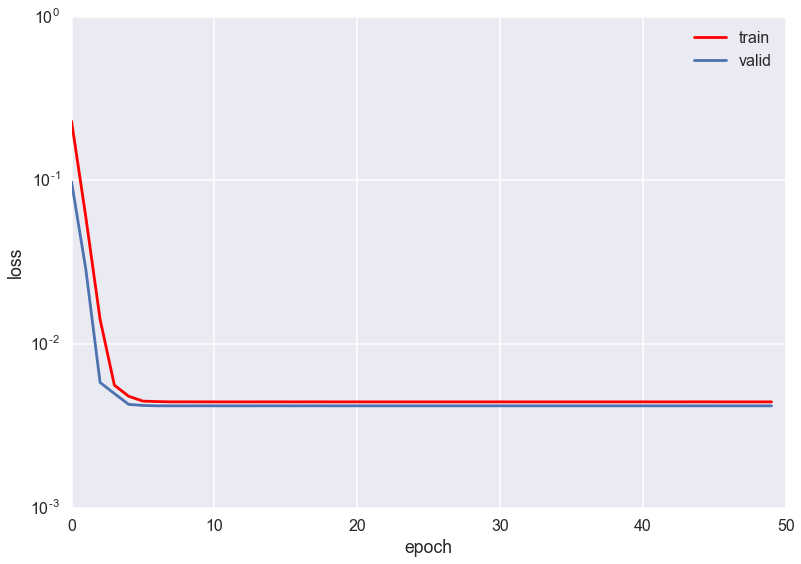

In [111]:
# increase learning rate

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net5 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        , ('dropout_0', layers.DropoutLayer)
        ,('hidden1', layers.DenseLayer)
        , ('dropout_1', layers.DropoutLayer)
        ,('hidden2', layers.DenseLayer)   
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden1_num_units=100,  # number of units in hidden layer
    hidden2_num_units=100,  # number of units in hidden layer
    dropout_0_p=0.5,
    dropout_1_p=0.5,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.05,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=50,  # we want to train this many epochs
    verbose=1,
)

net5.fit(X, y)

plot_training_history(net5)

# Neural Network with 934830 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input        9216
  1  dropout_0    9216
  2  hidden1       100
  3  dropout_1     100
  4  hidden2       100
  5  output         30

  epoch    train loss    valid loss      train/val  dur
-------  ------------  ------------  -------------  -----
      1  705834.44380       0.14611  4830950.78850  0.72s
      2       0.14675       0.14482      1.01335  0.75s
      3       0.14503       0.14255      1.01738  0.77s
      4       0.14213       0.13885      1.02355  0.76s
      5       0.13739       0.13267      1.03556  0.74s
      6       0.12909       0.12143      1.06312  0.78s
      7       0.11415       0.10181      1.12120  0.79s
      8       0.08983       0.07245      1.23989  0.77s
      9       0.05745       0.03877      1.48179  0.77s
     10       0.02654       0.01396      1.90149  0.76s
     11       0.00907       0.00509      1.78173  0.75s
     12   

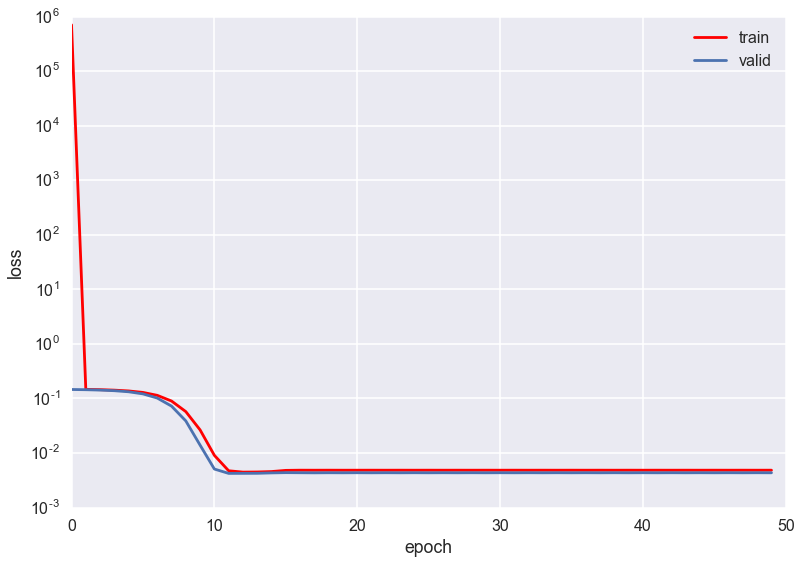

In [122]:
# try rmsprop activation

import theano

from lasagne.nonlinearities import sigmoid, rectify, very_leaky_rectify
# scaled_tanh = ScaledTanH()

def float32(k):
    return np.cast['float32'](k)


class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

        

net6 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        , ('dropout_0', layers.DropoutLayer)
        ,('hidden1', layers.DenseLayer)
        , ('dropout_1', layers.DropoutLayer)
        ,('hidden2', layers.DenseLayer)   
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden1_num_units=100,  # number of units in hidden layer
    hidden1_nonlinearity=rectify, # can also try sigmoid
    hidden2_num_units=100,  # number of units in hidden layer
    hidden2_nonlinearity=rectify,
    dropout_0_p=0.50,
    dropout_1_p=0.50,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values
    
    
    # optimization method:
    update=rmsprop,
#     update_learning_rate=0.005,
#     update_momentum=0.85,
    update_learning_rate=theano.shared(float32(0.05)),
#     update_momentum=theano.shared(float32(0.9)),

    
# adjust learning rate: uncomment if interested:    
#     on_epoch_finished=[
#         AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
#         AdjustVariable('update_momentum', start=0.9, stop=0.999),
#         ],
    
    
    
    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=50,  # we want to train this many epochs
    verbose=1,
)

net6.fit(X, y)

plot_training_history(net6)

# Neural Network with 934830 learnable parameters

## Layer information

  #  name         size
---  ---------  ------
  0  input        9216
  1  dropout_0    9216
  2  hidden1       100
  3  dropout_1     100
  4  hidden2       100
  5  output         30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.15598       0.03413      4.57012  0.61s
      2       0.02529       0.01154      2.19105  0.59s
      3       0.01565       0.01095      1.42913  0.56s
      4       0.01143       0.01032      1.10713  0.55s
      5       0.01012       0.00904      1.11937  0.55s
      6       0.00905       0.00843      1.07320  0.56s
      7       0.00825       0.00744      1.10791  0.56s
      8       0.00774       0.00688      1.12526  0.56s
      9       0.00709       0.00695      1.01998  0.60s
     10       0.00701       0.00651      1.07636  0.56s
     11       0.00647       0.00601      1.07661  0.55s
     12       0.

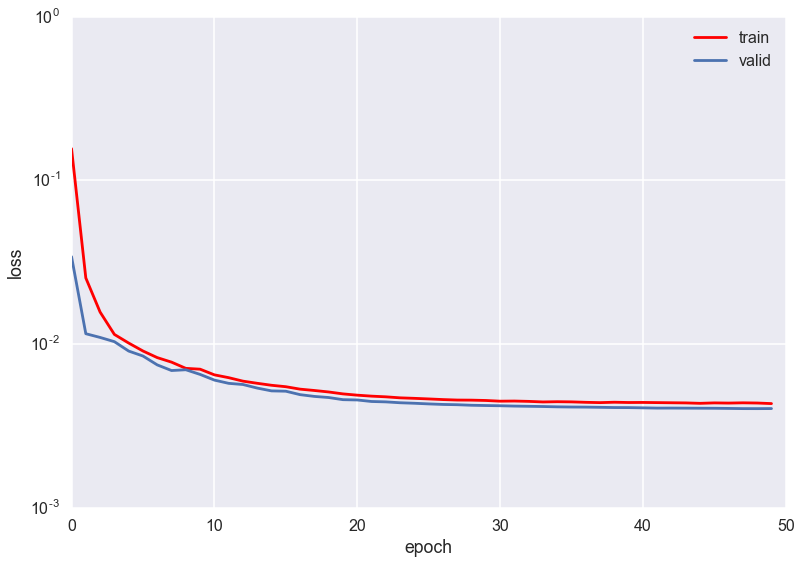

In [119]:
# change dropout rates a bit

from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net7 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer)
        , ('dropout_0', layers.DropoutLayer)
        ,('hidden1', layers.DenseLayer)
        , ('dropout_1', layers.DropoutLayer)
        ,('hidden2', layers.DenseLayer)   
        ,('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden1_num_units=100,  # number of units in hidden layer
    hidden2_num_units=100,  # number of units in hidden layer
    dropout_0_p=0.75,
    dropout_1_p=0.10,
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update_learning_rate=theano.shared(float32(0.05)),
    update_momentum=theano.shared(float32(0.9)),

    
# adjust learning rate:
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.05, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=50,  # we want to train this many epochs
    verbose=1,
)

net7.fit(X, y)

plot_training_history(net7)

In [ ]:
# try your own
# http://lasagne.readthedocs.org/en/latest/index.html